In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set_style('whitegrid')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

train = pd.read_csv('data/train.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeeuhnkim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeeuhnkim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jeeuhnkim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train = train.drop(['severe_toxic','obscene','threat', 'insult','identity_hate'],axis = 1)
df_train = train.sample(frac=.8,random_state = 123).copy()
df_valid = train.drop(df_train.index).copy()

df_train.to_csv('data/df_train.csv', header = True, index = True)
df_valid.to_csv('data/df_valid.csv', header = True, index = True)

In [4]:
df_train.head()

,id,comment_text,toxic
50446,86e395fd449fac16,", and redirect the other names to it",0
81571,da2d01ad7a9e23fb,SineBot1\nPlease read the above comments.,0
25983,44d17de5e7064a55,Thank you for your very good answer. I just r...,0
39022,681bceb39ce09938,"""\n I think we need to ask who is likely to be...",0
49431,8432afd4ddd2e1be,"Orangemonster2k1|SVRTVDude]] (VT) 23:26, 30 April",0


In [5]:
df_valid.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
25,000eefc67a2c930f,Radial symmetry \n\nSeveral now extinct lineag...,0
30,0011cc71398479c4,How could I post before the block expires? Th...,0


## value counts + histograms

0    0.904228
1    0.095772
Name: toxic, dtype: float64


<Axes: title={'center': 'Count (target)'}>

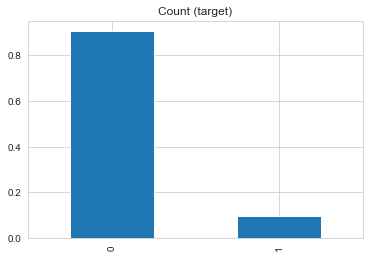

In [6]:
print(df_train.toxic.value_counts(normalize = True))
df_train.toxic.value_counts(normalize = True).plot(kind='bar', title='Count (target)')

## data preprocesing

In [7]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


In [8]:
def remove_stop(tokens) :
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

## add tokens column to df_train,df_valid dataframes

In [9]:
df_train['words'] = df_train['comment_text'].apply(lambda x : preprocess(x).split(" "))
df_train['ns_words'] = df_train['words'].apply(remove_stop)

df_valid['words'] = df_valid['comment_text'].apply(lambda x : preprocess(x).split(" "))
df_valid['ns_words'] = df_valid['words'].apply(remove_stop)

df_train.to_csv('data/df_train.csv', header = True, index = True)
df_valid.to_csv('data/df_valid.csv', header = True, index = True)

In [10]:
df_train.head()

,id,comment_text,toxic,words,ns_words
50446,86e395fd449fac16,", and redirect the other names to it",0,"[and, redirect, the, other, names, to, it]","[redirect, names]"
81571,da2d01ad7a9e23fb,SineBot1\nPlease read the above comments.,0,"[sinebot1, please, read, the, above, comments]","[sinebot1, please, read, comments]"
25983,44d17de5e7064a55,Thank you for your very good answer. I just r...,0,"[thank, you, for, your, very, good, answer, i,...","[thank, good, answer, realized, reading, quest..."
39022,681bceb39ce09938,"""\n I think we need to ask who is likely to be...",0,"[i, think, we, need, to, ask, who, is, likely,...","[think, need, ask, likely, visiting, disambigu..."
49431,8432afd4ddd2e1be,"Orangemonster2k1|SVRTVDude]] (VT) 23:26, 30 April",0,"[orangemonster2k1svrtvdude, vt, 2326, 30, april]","[orangemonster2k1svrtvdude, vt, 2326, 30, april]"


In [11]:
df_valid.head()

,id,comment_text,toxic,words,ns_words
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,"[more, i, cant, make, any, real, suggestions, ...","[cant, make, real, suggestions, improvement, w..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]"
25,000eefc67a2c930f,Radial symmetry \n\nSeveral now extinct lineag...,0,"[radial, symmetry, several, now, extinct, line...","[radial, symmetry, several, extinct, lineages,..."
30,0011cc71398479c4,How could I post before the block expires? Th...,0,"[how, could, i, post, before, the, block, expi...","[could, post, block, expires, funny, thing, th..."


## a look at toxic documents(train)

In [12]:
df_train.comment_text[df_train.toxic == 1].head()

90901     Removed idiotic criticism \n\nYou can write a ...
33839     I'm starting to get confused. Would Why Not a ...
98775     I don't compare people to Hitler because that ...
131973    "\n\nTHIS IS MY REPLY TO YOU THAT YOU HAVE DEL...
23477     Evasion is a lesbian sinner who did sexual soc...
Name: comment_text, dtype: object

In [13]:
#word counts with stop
word_dict = {'<unk>' : 0}

for i,tokens in enumerate(df_train.words) :
    for token in tokens :
        if token not in word_dict :
            word_dict[token] = 1
        else :
            word_dict[token] += 1
            
#word counts without stop
ns_word_dict = {'<unk>' : 0}

for i,tokens in enumerate(df_train.ns_words) :
    for token in tokens :
        if token not in ns_word_dict :
            ns_word_dict[token] = 1
        else :
            ns_word_dict[token] += 1
    

In [14]:
# words counted with descending order
df_word_counts = pd.DataFrame.from_dict(word_dict, orient='index', columns=['count'])
df_word_counts.sort_values(by=['count'], ascending=False, inplace=True)
df_word_counts.to_csv('data/df_word_counts.csv', header = True, index = True)
df_word_counts.head(10)

,count
the,396575
to,237320
of,179051
and,177746
a,170469
you,163472
i,159886
is,140302
that,123467
in,115185


In [15]:
# nonstop words counted with descending order
df_ns_word_counts = pd.DataFrame.from_dict(ns_word_dict, orient='index', columns=['count'])
df_ns_word_counts.sort_values(by=['count'], ascending=False, inplace=True)
df_ns_word_counts.to_csv('data/df_ns_word_counts.csv', header = True, index = True)
df_ns_word_counts.head(10)

,count
article,44271
page,36558
wikipedia,27824
talk,24858
please,23654
would,23486
one,22299
like,22022
dont,20971
see,17136


In [16]:
#word counts with stop among toxic comments
toxic_word_dict = {}

for tokens in df_train.words[df_train.toxic == 1] :
    for token in tokens :
        if token not in toxic_word_dict :
            toxic_word_dict[token] = 1
        else :
            toxic_word_dict[token] += 1

#word counts without stop among toxic comments
toxic_ns_word_dict = {}

for tokens in df_train.ns_words[df_train.toxic == 1] :
    for token in tokens :
        if token not in toxic_ns_word_dict :
            toxic_ns_word_dict[token] = 1
        else :
            toxic_ns_word_dict[token] += 1

In [17]:
# words counted among toxic comments in descending order
df_toxic_word_counts = pd.DataFrame.from_dict(toxic_word_dict, orient='index', columns=['count'])
df_toxic_word_counts.sort_values(by=['count'], ascending=False, inplace=True)
df_toxic_word_counts.head(20)

,count
you,27946
the,16319
i,16024
a,15756
to,12611
and,12489
is,10112
of,9276
your,6579
are,6325


In [18]:
# nonstop words counted among toxic comments in descending order
df_toxic_ns_word_counts = pd.DataFrame.from_dict(toxic_ns_word_dict, orient='index', columns=['count'])
df_toxic_ns_word_counts.sort_values(by=['count'], ascending=False, inplace=True)
df_toxic_ns_word_counts.head(10)

,count
fuck,6319
shit,3077
nigger,3073
dont,2943
like,2906
suck,2675
fucking,2520
wikipedia,2345
u,2270
hate,2216


# 2. BIGRAMS

In [19]:
df_train['bigrams'] = df_train.words.apply(lambda x : list(nltk.bigrams(x)))
df_valid['bigrams'] = df_valid.words.apply(lambda x : list(nltk.bigrams(x)))

df_train.to_csv('data/df_train.csv', header = True, index = True)
df_valid.to_csv('data/df_valid.csv', header = True, index = True)

In [20]:
df_train.head()

,id,comment_text,toxic,words,ns_words,bigrams
50446,86e395fd449fac16,", and redirect the other names to it",0,"[and, redirect, the, other, names, to, it]","[redirect, names]","[(and, redirect), (redirect, the), (the, other..."
81571,da2d01ad7a9e23fb,SineBot1\nPlease read the above comments.,0,"[sinebot1, please, read, the, above, comments]","[sinebot1, please, read, comments]","[(sinebot1, please), (please, read), (read, th..."
25983,44d17de5e7064a55,Thank you for your very good answer. I just r...,0,"[thank, you, for, your, very, good, answer, i,...","[thank, good, answer, realized, reading, quest...","[(thank, you), (you, for), (for, your), (your,..."
39022,681bceb39ce09938,"""\n I think we need to ask who is likely to be...",0,"[i, think, we, need, to, ask, who, is, likely,...","[think, need, ask, likely, visiting, disambigu...","[(i, think), (think, we), (we, need), (need, t..."
49431,8432afd4ddd2e1be,"Orangemonster2k1|SVRTVDude]] (VT) 23:26, 30 April",0,"[orangemonster2k1svrtvdude, vt, 2326, 30, april]","[orangemonster2k1svrtvdude, vt, 2326, 30, april]","[(orangemonster2k1svrtvdude, vt), (vt, 2326), ..."


In [21]:
df_valid.head()

,id,comment_text,toxic,words,ns_words,bigrams
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,...","[(explanation, why), (why, the), (the, edits),..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,"[more, i, cant, make, any, real, suggestions, ...","[cant, make, real, suggestions, improvement, w...","[(more, i), (i, cant), (cant, make), (make, an..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]","[(you, sir), (sir, are), (are, my), (my, hero)..."
25,000eefc67a2c930f,Radial symmetry \n\nSeveral now extinct lineag...,0,"[radial, symmetry, several, now, extinct, line...","[radial, symmetry, several, extinct, lineages,...","[(radial, symmetry), (symmetry, several), (sev..."
30,0011cc71398479c4,How could I post before the block expires? Th...,0,"[how, could, i, post, before, the, block, expi...","[could, post, block, expires, funny, thing, th...","[(how, could), (could, i), (i, post), (post, b..."


In [22]:
#bigram counts with stop
bigram_dict = {'<unk>' : 0}

for bigrams in df_train.bigrams :
    for bigram in bigrams :
        if bigram not in bigram_dict :
            bigram_dict[bigram] = 1
        else :
            bigram_dict[bigram] += 1

#bigram counts among toxic comments
toxic_bigram_dict = {'<unk>' : 0}

for bigrams in df_train.bigrams[df_train.toxic == 1] :
    for bigram in bigrams :
        if bigram not in toxic_bigram_dict :
            toxic_bigram_dict[bigram] = 1
        else :
            toxic_bigram_dict[bigram] += 1

In [23]:
# bigram counts in descending order
df_bigram_counts = pd.DataFrame.from_dict(bigram_dict, orient='index', columns=['count'])
df_bigram_counts.sort_values(by=['count'], ascending=False, inplace=True)
df_bigram_counts.to_csv('data/df_bigram_counts.csv', header = True, index = True)
df_bigram_counts.head(10)

,count
"(of, the)",40122
"(in, the)",30165
"(to, the)",21294
"(if, you)",21142
"(on, the)",18565
"(the, article)",17952
"(it, is)",17286
"(to, be)",17098
"(is, a)",15526
"(you, are)",13526


In [24]:
# bigram counts among toxic comments in descending order
df_toxic_bigram_counts = pd.DataFrame.from_dict(toxic_bigram_dict, orient='index', columns=['count'])
df_toxic_bigram_counts.sort_values(by=['count'], ascending=False, inplace=True)
df_toxic_bigram_counts.head(10)

,count
"(you, are)",3098
"(i, am)",2614
"(is, a)",2523
"(fuck, you)",2271
"(nigger, nigger)",2015
"(pig, pig)",1249
"(you, fuck)",1225
"(are, a)",1201
"(of, the)",1171
"(shit, shit)",1145


In [25]:
df_train['ns_bigrams'] = df_train.ns_words.apply(lambda x : list(nltk.bigrams(x)))
df_valid['ns_bigrams'] = df_valid.ns_words.apply(lambda x : list(nltk.bigrams(x)))

df_train.to_csv('data/df_train.csv', header = True, index = True)
df_valid.to_csv('data/df_valid.csv', header = True, index = True)

In [26]:
df_train.head()

,id,comment_text,toxic,words,ns_words,bigrams,ns_bigrams
50446,86e395fd449fac16,", and redirect the other names to it",0,"[and, redirect, the, other, names, to, it]","[redirect, names]","[(and, redirect), (redirect, the), (the, other...","[(redirect, names)]"
81571,da2d01ad7a9e23fb,SineBot1\nPlease read the above comments.,0,"[sinebot1, please, read, the, above, comments]","[sinebot1, please, read, comments]","[(sinebot1, please), (please, read), (read, th...","[(sinebot1, please), (please, read), (read, co..."
25983,44d17de5e7064a55,Thank you for your very good answer. I just r...,0,"[thank, you, for, your, very, good, answer, i,...","[thank, good, answer, realized, reading, quest...","[(thank, you), (you, for), (for, your), (your,...","[(thank, good), (good, answer), (answer, reali..."
39022,681bceb39ce09938,"""\n I think we need to ask who is likely to be...",0,"[i, think, we, need, to, ask, who, is, likely,...","[think, need, ask, likely, visiting, disambigu...","[(i, think), (think, we), (we, need), (need, t...","[(think, need), (need, ask), (ask, likely), (l..."
49431,8432afd4ddd2e1be,"Orangemonster2k1|SVRTVDude]] (VT) 23:26, 30 April",0,"[orangemonster2k1svrtvdude, vt, 2326, 30, april]","[orangemonster2k1svrtvdude, vt, 2326, 30, april]","[(orangemonster2k1svrtvdude, vt), (vt, 2326), ...","[(orangemonster2k1svrtvdude, vt), (vt, 2326), ..."


In [27]:
df_valid.head()

,id,comment_text,toxic,words,ns_words,bigrams,ns_bigrams
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,...","[(explanation, why), (why, the), (the, edits),...","[(explanation, edits), (edits, made), (made, u..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,"[more, i, cant, make, any, real, suggestions, ...","[cant, make, real, suggestions, improvement, w...","[(more, i), (i, cant), (cant, make), (make, an...","[(cant, make), (make, real), (real, suggestion..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]","[(you, sir), (sir, are), (are, my), (my, hero)...","[(sir, hero), (hero, chance), (chance, remembe..."
25,000eefc67a2c930f,Radial symmetry \n\nSeveral now extinct lineag...,0,"[radial, symmetry, several, now, extinct, line...","[radial, symmetry, several, extinct, lineages,...","[(radial, symmetry), (symmetry, several), (sev...","[(radial, symmetry), (symmetry, several), (sev..."
30,0011cc71398479c4,How could I post before the block expires? Th...,0,"[how, could, i, post, before, the, block, expi...","[could, post, block, expires, funny, thing, th...","[(how, could), (could, i), (i, post), (post, b...","[(could, post), (post, block), (block, expires..."


In [28]:
#nonstop bigram counts 
ns_bigram_dict = {'<unk>' : 0}

for bigrams in df_train.ns_bigrams :
    for bigram in bigrams :
        if bigram not in ns_bigram_dict :
            ns_bigram_dict[bigram] = 1
        else :
            ns_bigram_dict[bigram] += 1

#nonstop bigram counts among toxic comments
ns_toxic_bigram_dict = {'<unk>' : 0}

for bigrams in df_train.ns_bigrams[df_train.toxic == 1] :
    for bigram in bigrams :
        if bigram not in ns_toxic_bigram_dict :
            ns_toxic_bigram_dict[bigram] = 1
        else :
            ns_toxic_bigram_dict[bigram] += 1

In [29]:
# nonstop bigram counts in descending order
df_ns_bigram_counts = pd.DataFrame.from_dict(ns_bigram_dict, orient='index', columns=['count'])
df_ns_bigram_counts.sort_values(by=['count'], ascending=False, inplace=True)
df_ns_bigram_counts.to_csv('data/df_ns_bigram_counts.csv', header = True, index = True)
df_ns_bigram_counts.head(10)

,count
"(talk, page)",10498
"(speedy, deletion)",3568
"(would, like)",2906
"(dont, know)",2342
"(fair, use)",2148
"(nigger, nigger)",2017
"(feel, free)",1872
"(blocked, editing)",1868
"(dont, think)",1819
"(please, stop)",1767


In [30]:
# nonstop bigram counts among toxic comments in descending order
df_ns_toxic_bigram_counts = pd.DataFrame.from_dict(ns_toxic_bigram_dict, orient='index', columns=['count'])
df_ns_toxic_bigram_counts.sort_values(by=['count'], ascending=False, inplace=True)
df_ns_toxic_bigram_counts.head(10)

,count
"(nigger, nigger)",2015
"(fuck, fuck)",1296
"(pig, pig)",1250
"(shit, shit)",1148
"(hi, moron)",1120
"(moron, hi)",1119
"(hate, hate)",970
"(suck, suck)",877
"(balls, balls)",833
"(bullshit, bullshit)",832
